# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Let's play real tennis

#### 3.1. Importing modules and adding some jupyter-notebook magic

##### 3.1.1. Importing modules

In [5]:
from collections import deque, namedtuple
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
from torch import nn, optim
import torch.nn.functional as F

##### 3.1.2. Jupyter-notebook magic

The magic is here - let matplotlib in the lines.

In [6]:
%matplotlib inline

#### 3.2. Parameters

##### 3.2.1. CONSTANTS

The following CONSTANTS influece the training process. Play with them if you're up to.

In [7]:
BATCH_SIZE = 1024		# Size of the replay buffer.
BUFFER_SIZE = int(1e5)	# Size of the mini batches.
GAMMA = 0.99			# Discount factor, Gamma.
L2_WEIGHT_DECAY = 0		# L2 weight decay.
LR_ACTOR = 2e-4			# Learning rate of the actor.
LR_CRITIC = 1e-3		# Learning rate of the critic.
RANDOM_SEED = 12345		# An integer to fire up random generators.
TAU = 1e-3				# Parameter Tau serves to set soft update of target parameters.

##### 3.2.2. Globally significant variables

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Training on {}.'.format(device))

Training on cuda.


#### 3.3. Classes

##### 3.3.1. Actor

In [9]:
class Actor(nn.Module):
    """
    This class represents an Actor (Policy) Model. It inherts from PyTorch NN Module.
    __init__(), forward() and reset_parameters() are overwritten only.
    """



    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """
        Initializes the class.
        ----------------------
        @Params:	state_size	(int)	Count of state's dimensions.
                    action_size	(int)	Count of action's dimensions.
                    seed		(int)	Rendom seed.
                    fc1_size	(int)	[optional] Count of nodes in the 1st fully connected layer.
                    fc2_size	(int)	[optional] Count of nodes in the 2nd fully connected layer.
        """
        super(Actor, self).__init__()

        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
        self.reset_parameters()



    def forward(self, state):
        """
        Fordwards the input (state) through the whole network and returns the network's output.
        ---------------------------------------------------------------------------------------
        @Params:	state	(torch.Tensor)	Input data (state).
        @Return:	(torch.Tensor)			The output of the network (action).
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        return torch.tanh(self.fc3(x))



    def reset_parameters(self):
        """
        Resets weights.
        ---------------
        """
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-0.003, 0.003)

##### 3.3.2. Agent

In [10]:
class Agent(object):
    """
    This class represents an agent who inteacts with the environment and can learn from it.
    This class doesn't really have any superclass aside of object which is the top most superclass usually.
    """



    def __init__(self, state_size, action_size, num_agents, random_seed):
        """
        Initializes the class.
        ----------------------
        @Params:	state_size		(int)	Count of state's dimensions.
                    action_size		(int)	Count of action's dimensions.
                    num_agents		(int)	Number of agents.
                    seed			(int)	Rendom seed.
        """
        global BATCH_SIZE
        global BUFFER_SIZE
        global EPSILON
        global LR_ACTOR
        global LR_CRITIC
        global L2_WEIGHT_DECAY
        
        global davice
        
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=L2_WEIGHT_DECAY)

        self.noise = Noise((num_agents, action_size), random_seed)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)



    def act(self, states, act_noisy=True):
        """
        Performs an action from the given state and adds noise actions if needed.
        -------------------------------------------------------------------------
        @Params:	states		(array like)	Current state.
                    act_noisy	(boolean)		Whether to add noise or not.
        """
        global device
        
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        
        if act_noisy:
            actions += self.noise.sample()
        
        # Keep valid action samples only.
        return np.clip(actions, -1, 1)



    def learn(self, experiences, gamma):
        """
        Performs experience based update of parameters.
        -----------------------------------------------
        @Params:	experience	(tuple)	Experiences to work with.
                    gamma		(float)	The value of the discount factor.
        """
        global TAU
        
        states, actions, rewards, next_states, dones = experiences
        
        # Those lines below serve to calculate targets and Q-values.
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        
        # Critic network is updated here.
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Finally actor netowrk is updated too with the help of the critic network.
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Both actor and critic network need a soft update.
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)



    def reset(self):
        """
        Resets the used noise.
        ----------------------
        """
        self.noise.reset()



    def soft_update(self, local_model, target_model, tau):
        """
        Performs soft update on model parameters.
        -----------------------------------------
        @Params:	local_model		(nn.Module)	Model to copy weights from.
                    target_model	(nn.Module)	Model to copy weights to.
                    tau				(float)		Parameter of interpolation.
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)



    def step(self, state, action, reward, next_state, done):
        """
        Takes a step in the action-space and calls learning if needed.
        --------------------------------------------------------------
        @Params:	state		(float)	Current state.
                    action		(float)	Taken action.
                    reward		(float)	Received reward.
                    next_state	(float)	Next state (resulting state).
                    done		(float)	Whether it's finished or not.
        """
        global BATCH_SIZE
        global GAMMA
        
        for i in range(self.num_agents):
            self.memory.add(state[i, :], action[i, :], reward[i], next_state[i, :], done[i])

        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

##### 3.3.3. Critic

In [11]:
class Critic(nn.Module):
    """
    This class represents a Critic (Value) Model. It inherts from PyTorch NN Module.
    __init__(), forward() and reset_parameters() are overwritten only.
    """



    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """
        Initializes the class.
        ----------------------
        @Params:	state_size	(int)	Count of state's dimensions.
                    action_size	(int)	Count of action's dimensions.
                    seed		(int)	Rendom seed.
                    fc1_size	(int)	[optional] Count of nodes in the 1st fully connected layer.
                    fc2_size	(int)	[optional] Count of nodes in the 2nd fully connected layer.
        """
        super(Critic, self).__init__()

        self.seed = torch.manual_seed(seed)
        
        self.fcs1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.reset_parameters()



    def forward(self, state, action):
        """
        Fordwards the input (state) through the whole network and returns the network's output.
        ---------------------------------------------------------------------------------------
        @Params:	state	(torch.Tensor)	States.
                    action	(torch.Tensor)	Actions.
        @Return:	(torch.Tensor)			Q-targets.
        """
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))

        return self.fc3(x)



    def reset_parameters(self):
        """
        Resets weights.
        ---------------
        """
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-0.003, 0.003)

##### 3.3.4. Noise

In [12]:
class Noise(object):
    """
    This class creates noise to the training process. It implements the Ornstein-Uhlenbeck process.
    This class doesn't really have any superclass aside of object which is the top most superclass usually.
    """



    def __init__(self, size, seed, mu=0.0, theta=0.15, sigma=0.2):
        """
        Initializes the class.
        ----------------------
        @Params:	size	(int)	The size of the noise.
                    seed	(int)	Rendom seed.
                    mu		(float)	[optional] Base value of mu.
                    theta	(float)	[optional] Value of theta.
                    sigma	(float)	[optional] Value of sigma.
        """
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        
        self.seed = random.seed(seed)
        
        self.reset()



    def reset(self):
        """
        Resets the class's state to the default.
        ----------------------------------------
        """
        self.state = copy.copy(self.mu)



    def sample(self):
        """
        Samples random noise from state and updates the state.
        ------------------------------------------------------
        @Return:	(np.ndarray)	Noise.
        """
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        
        return self.state

##### 3.3.5. Replay buffer

In [13]:
class ReplayBuffer(object):
    """
    This class represents the experience of the agent.
    This class doesn't really have any superclass aside of object which is the top most superclass usually.
    """



    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Initializes the class.
        ----------------------
        @Params:	action_size	(int)	Count of action's dimensions.
                    buffer_size	(int)	Size of the actual buffer.
                    batch_size	(int)	Size of training batches.
                    seed		(int)	Rendom seed.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
        self.seed = random.seed(seed)



    def add(self, state, action, reward, next_state, done):
        """
        Adds a new experience to the memory.
        ------------------------------------
        @Params:	state		(float)	Current state.
                    action		(float)	Taken action.
                    reward		(float)	Received reward.
                    next_state	(float)	Next state (resulting state).
                    done		(float)	Whether it's finished or not.
        """
        newexperience = self.experience(state, action, reward, next_state, done)
        self.memory.append(newexperience)



    def sample(self):
        """
        Samples random batches from the memory.
        ---------------------------------------
        @Return:	(tuple)	Batch
        """
        global device

        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)



    def __len__(self):
        """
        Returns the size of the buffer's memory and ensures the compatibility with the len() function.
        """
        return len(self.memory)

#### 3.4. Helper functions

In [14]:
def drawresults(scores, save_to=None):
    """
    Draws and saves scores.
    -----------------------
    @Params:	scores	(list like)	Scores to display.
                save_to	(string)	[optional] File name to save figure if given.
    """
    fig, ax = plt.subplots(1, 1, figsize=[10, 5])
    plt.rcParams.update({'font.size': 16})
    scores_rolling = pd.Series(scores).rolling(100).mean()
    ax.plot(scores)
    ax.plot(scores_rolling, c="green", linewidth=3)
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Score")
    ax.grid(which="major")
    ax.axhline(0.5, c="red", linewidth=3)
    ax.legend(["Scores of episodes", "Average of last 100 episodes", "Target score=0.5"])
    
    if save_to != None:
        fig.savefig(save_to)



def hidden_init(layer):
    """
    Initializes a layer with the process of: 1.0 / sqrt(layer)
    ----------------------------------------------------------
    @Params:	layer	(torch.Tensor)	Layer to initialize.
    @Return:	(torch.Tensor)			The initialized layer.
    """
    layer_n = layer.weight.data.size()[0]
    lim = 1.0 / np.sqrt(layer_n)

    return (-lim, lim)



def train(episodes_count=50000, print_at_every=100):
    """
    Performs the training
    ---------------------
    @Params:	episode_count	(int)	[optional] Count of episodes.
                print_at_every	(int)	[optional] Length of the interval of episodes to log like print the result.
    @Return:	(list of ints)			Scores
    """
    global agent
    global brain_name
    global env
    global num_agents
    
    scores_deque = deque(maxlen=100)
    all_scores = []
    
    # The value of episode is more human like this way since it changes from 1...x instead of 0...x-1 and
    # shows the number of the actual episode just like humans understand more.
    for episode in range(1, episodes_count+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        
        # The line below doesn't look like a cite from the book "Best practices in loops" but this time
        # it'll serve just fine since someone should win anyway.
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            scores += np.array(rewards)
            states = next_states            

            # Break out from infinity if anyone finished this game.
            if np.any(dones):
                break
        
        scores_deque.append(np.amax(scores))
        all_scores.append(np.amax(scores))
        
        print('\rEpisode {:4d}:\tAverage of last 100 scores is {:.4f}.\tScore of agent_1:{:.4f}.\tScore of agent_2:{:.4f}.  '
              .format(episode, np.mean(scores_deque), scores[0], scores[1]), end='')
                
        if episode % print_at_every == 0:
            print('\rEpisode {:4d}:\tAverage of last 100 scores is {:.4f}.\tScore of agent_1:{:.4f}.\tScore of agent_2:{:.4f}.  '
                  .format(episode, np.mean(scores_deque), scores[0], scores[1]))
                        
        if np.mean(scores_deque) >= 0.5:
            print('\n\nTraining finished.')
            print('\rEpisode {:4d}:\tAverage of last 100 scores is {:.4f}.\tScore of agent_1:{:.4f}.\tScore of agent_2:{:.4f}.  '
                  .format(episode, np.mean(scores_deque), scores[0], scores[1]))
            torch.save(agent.actor_local.state_dict(), "tennis_actor.pth")
            torch.save(agent.critic_local.state_dict(), "tennis_critic.pth")
            break

    return all_scores    

#### 3.5. Let's touch those arms

##### 3.5.1. Instantiate the agent

In [15]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=RANDOM_SEED)

##### 3.5.2. Train the agent

In [16]:
scores = train()

Episode  100:	Average of last 100 scores is 0.0020.	Score of agent_1:0.0000.	Score of agent_2:-0.0100.  
Episode  200:	Average of last 100 scores is 0.0000.	Score of agent_1:-0.0100.	Score of agent_2:0.0000.  
Episode  300:	Average of last 100 scores is 0.0000.	Score of agent_1:0.0000.	Score of agent_2:-0.0100.  
Episode  400:	Average of last 100 scores is 0.0000.	Score of agent_1:-0.0100.	Score of agent_2:0.0000.  
Episode  500:	Average of last 100 scores is 0.0000.	Score of agent_1:0.0000.	Score of agent_2:-0.0100.  
Episode  600:	Average of last 100 scores is 0.0078.	Score of agent_1:0.0000.	Score of agent_2:-0.0100.  
Episode  700:	Average of last 100 scores is 0.0155.	Score of agent_1:0.0000.	Score of agent_2:-0.0100.  
Episode  800:	Average of last 100 scores is 0.0138.	Score of agent_1:-0.0100.	Score of agent_2:0.0000.  
Episode  900:	Average of last 100 scores is 0.0010.	Score of agent_1:0.0000.	Score of agent_2:-0.0100.  
Episode 1000:	Average of last 100 scores is 0.0000.	Sco

##### 3.5.3. See the scores

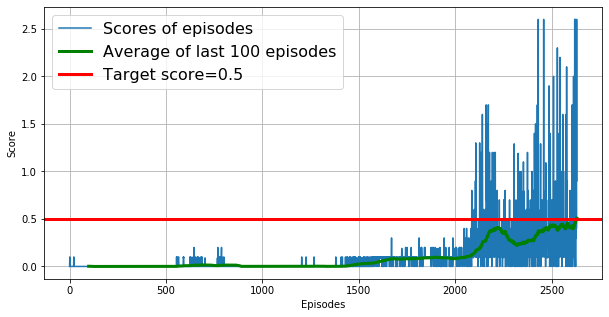

In [17]:
drawresults(scores, './tennis_scores.jpg')

#### 3.6. Test the trained agent

In [18]:
# This time I'll use standard random seed 0 to ignite random things again.
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

agent.actor_local.load_state_dict(torch.load("tennis_actor.pth"))
agent.critic_local.load_state_dict(torch.load("tennis_critic.pth"))

env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)

# Let's face the potential infinity once more.
while True:
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += env_info.rewards
    states = next_states
    
    # Break out from infinity if anyone finished this game.
    if np.any(dones):
        break

print('if a well trained agent plays against itself, the mean of scores is {:.4f}.'.format(np.mean(scores)))

if a well trained agent plays against itself, the mean of scores is 0.0950.


#### 3.7. The end

In [19]:
env.close()